# RL

**Выполнять задание следует с текущими значениями гиперпараметров. Для проверки ниже будут приведены ответы, которые должны получиться в результате выполнения задания.**

После того, как заявленные значения совпадут и будут получены работающие модели выполните следующие задания:

1. **Базовая часть (3 балла):** исследуйте влияние параметров `gamma, lr_rate, epsilon` на обучение моделей. Постройте графики.
2. **Опциональная часть (+2 балла):** Реализуйте остальные стратегии выбора действий (softmax, UCB, оптимистичные начальные оценки), описанные в лекции. Визуализируйте результаты.

Зададим гиперпараметры модели

In [ ]:
epsilon = 0.1 # Параметр эпсилон при использовании эпсилон жадной стратегии
gamma = 0.8 # Коэффциент дисконтирования гамма
random_seed = 100 #Random seed
time_delay = 1 # Задержка времени при отрисовке процесса игры после обучения (секунды)
lr_rate = 0.9 #Коэффициент скорости обучения альфа

Импортируем библиотеки, создаем свою среду размера 6х6. S обозначает точку старта. F -- лед безопасен, H -- проталина, G -- цель. Параметр `is_slippery=False` отвечает за условное отсутствие скольжения. То есть если агент выбрал действие пойти направо, то он переместится в соответствующее состояние. В общем случае из-за "скольжения" можно оказаться в другом состоянии. Мы также скопировали из библиотки GYM и слегка модифицировали функцию ```generate_random_map ```, для того, чтобы генерировать произвольные карты на основе ```random_seed ```.





In [ ]:
# Установим нужную версию библиотеки gym
!git clone https://github.com/dvolchek/gym_0_18_0.git -q
%cd /content/gym_0_18_0
!pip install -e. -q

/content/gym_0_18_0
  Preparing metadata (setup.py) ... done


In [ ]:
import gym
import numpy as np
import time
from IPython.display import clear_output


def generate_random_map(size, p, sd):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False
    np.random.seed(sd)

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

#Генерация карты
random_map = generate_random_map(size=6, p=0.8, sd = random_seed) #Создаем свою карту
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) #Инициализируем среду
print("Ваша карта")
env.render() #Выводим карту на экран

Ваша карта

SFFHFF
FHFFHF
FFFHHF
HFFHHF
FFFFFF
FFFFFG


Функции выбора действия и обновления таблицы ценности действий. Строчка *** используется для того, чтобы проверять ответы в openedx. Вне рамках академической задачи лучше использовать оригинальный метод класса `environment`, то есть:

`action = env.action_space.sample()`

# Задача 1
Дополните функцию ```learn()```, чтобы в результате ее вызова обновлялось значение ценности текущего действия согласно алгоритму Q-обучения



In [ ]:
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, state2, reward, action, done):
    if done:
      Q[state, action] = Q[state, action] = Q[state, action] + lr_rate * (reward - Q[state, action])
    else:
      Q[state, action] = Q[state, action] + lr_rate * (reward + gamma * np.max(Q[state2, :]) - Q[state, action])

# Задача 2
Дополните следующий код так, чтобы в результате обучения модели можно было узнать количество побед и номер игры (`game`), на котором агент впервые одержал пятую победу подряд.

Поясним, что возвращает функция ```env.step(action)```

```state2``` -- следующее состояние

```reward``` -- награда

```done``` -- флаг окончания игры. True в случае победы или падения в проталину. False в остальных случаях.




In [ ]:
from tqdm import tqdm
# Inititalization
np.random.seed(random_seed)
total_games = 10000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))

win_streak = 0  # Текущая серия побед
first_game_with_5_wins = None  # Номер игры, на которой впервые достигнуто 5 побед подряд
total_wins = 0  # Общее количество побед
#Main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    while t < max_steps:

        t += 1

        action = choose_action(state)

        state2, reward, done, info = env.step(action)

        if t == max_steps:
          done = True

        learn(state, state2, reward, action, done)

        state = state2

        if done:
          if reward == 1:  # Награда 1 соответствует победе
                game_won = True
                total_wins += 1  # Увеличиваем общее количество побед
                win_streak += 1  # Увеличиваем серию побед
                # Если достигнута серия из 5 побед подряд, фиксируем номер игры
                if win_streak == 5 and first_game_with_5_wins is None:
                    first_game_with_5_wins = game + 1  # Игры нумеруются с 0
          else:
                win_streak = 0  # Сбрасываем серию побед при поражении
          break


100%|██████████| 10000/10000 [00:07<00:00, 1385.99it/s]


Вывод ответов при заданных параметрах

In [ ]:
print("Количество побед в серии из 10 000 игр: ", total_wins)
print("Пять побед подряд впервые было одержано в игре ", first_game_with_5_wins)


Количество побед в серии из 10 000 игр:  7914
Пять побед подряд впервые было одержано в игре  885


Должны получиться следующие результаты.


*  Количество побед в серии из 10 000 игр:  7914
*  Пять побед подряд впервые было одержано в игре  885




Произведем одну игру, чтобы проследить за действиями агента. При этом будем считать модель полностью обученной, то есть действия выбираются жадно, значения ценностей действий в таблице не обновляются.

In [ ]:
import time
#Жадный выбор действий
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

states=[]#Массив для сохранения состояний агента в течение игры
t = 0
state = env.reset()
wn = 0
while(t<100):
  env.render()
  time.sleep(time_delay)
  clear_output(wait=True)
  action = choose_action_one_game(state)
  state2, reward, done, info = env.step(action)
  states.append(state)
  state = state2
  t += 1
  if done and reward == 1:
    wn=1
  if done:
    break
if wn == 1:
  print("!!!Победа!!!")

!!!Победа!!!


Отобразим маршрут

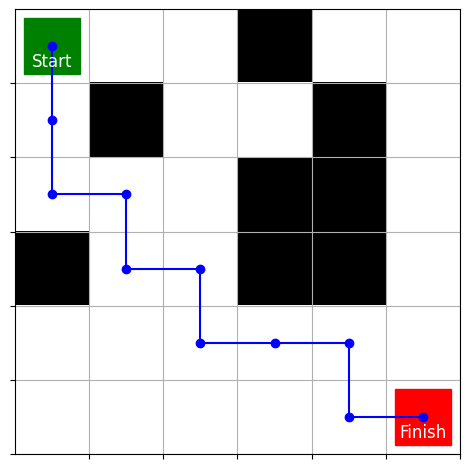

In [ ]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic=[]
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic


#Make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

#Arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
if wn == 1:
  rw = np.append(rw, [nrows-1])
  cl = np.append(cl,[ncols-1])

#Picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")

# Задача 3

Используйте вместо алгоритма Q-обучения алгоритм SARSA. Обратите внимание на то, что требуется изменить количество игр. То есть `total_games = 40000`. Запускать блоки следует последвательно с самого начала (из-за `random_seed`). Отдельно обращаем ваше внимание на то, что при изменении алгоритма с Q-обучения на SARSA модификации подлежит как процесс обучения, так и функция `learn()`. Кроме того, у функции `learn()` должен появиться дополнительный аргумент (следующее действие). Ниже приведен фрагмент кода с пояснениями, как именно нужно модифицировать алгоритм.



In [ ]:
def learn(state, state2, reward, action, action2, done):
    if done:
        Q[state, action] = Q[state, action] + lr_rate * (reward - Q[state, action])
    else:
        Q[state, action] = Q[state, action] + lr_rate * (
            reward + gamma * Q[state2, action2] - Q[state, action]
        )


In [ ]:
def choose_action(state):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, env.action_space.n)
    return np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))


In [ ]:
from tqdm import tqdm
import numpy as np

np.random.seed(random_seed)
total_games = 40000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))

win_streak = 0
first_game_with_5_wins = None
total_wins = 0

for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    action = choose_action(state)

    while t < max_steps:
        t += 1

        state2, reward, done, info = env.step(action)
        action2 = choose_action(state2)

        if t == max_steps:
            done = True

        learn(state, state2, reward, action, action2, done)

        state = state2
        action = action2

        if done:
            if reward == 1:
                total_wins += 1
                win_streak += 1
                if win_streak == 5 and first_game_with_5_wins is None:
                    first_game_with_5_wins = game + 1
            else:
                win_streak = 0
            break


100%|██████████| 40000/40000 [00:34<00:00, 1156.88it/s]


In [ ]:
print("Количество побед в серии из 40 000 игр: ", total_wins)
print("Пять побед подряд впервые было одержано в игре ", first_game_with_5_wins)

Количество побед в серии из 40 000 игр:  32328
Пять побед подряд впервые было одержано в игре  894


. В результате обучения должны получиться следующие ответы:



*   Количество побед в серии из 40 000 игр:  32328
*   Пять побед подряд впервые было одержано в игре  894

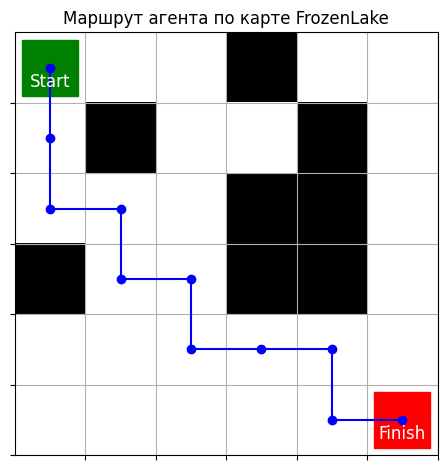

In [ ]:
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

# row и col по координатам состояний
rw = np.remainder(states, nrows)
cl = np.floor_divide(states, nrows)

# Добавим финиш, если победа
if wn == 1:
    rw = np.append(rw, [nrows-1])
    cl = np.append(cl, [ncols-1])

fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)

# Старт
ax1.plot([0], [0], "gs", markersize=40)
ax1.text(0, 0.2, "Start", ha="center", va="center", color="white", fontsize=12)

# Финиш
ax1.plot([nrows-1], [ncols-1], "rs", markersize=40)
ax1.text(nrows-1, ncols-1+0.2, "Finish", ha="center", va="center", color="white", fontsize=12)

# Маршрут
ax1.plot(rw, cl, ls='-', color='blue')  # путь
ax1.plot(rw, cl, "bo")  # точки посещения

# Отображение карты: 0 — белое, 1 — черное
ax1.imshow(maze_pic, cmap="binary")

plt.title("Маршрут агента по карте FrozenLake")
plt.show()


# Сравнение стратегий

In [ ]:
def train_agent(strategy, total_games=10000, epsilon=0.1, tau=1.0, c=1.0, init_q=0.0):
    Q = np.full((env.observation_space.n, env.action_space.n), init_q)
    N = np.zeros_like(Q)  # для UCB
    rewards = []

    for game in tqdm(range(total_games)):
        state = env.reset()
        total_reward = 0

        for _ in range(100):  # макс. шагов
            if strategy == "epsilon_greedy":
                if np.random.rand() < epsilon:
                    action = np.random.randint(env.action_space.n)
                else:
                    action = np.random.choice(np.flatnonzero(Q[state] == Q[state].max()))

            elif strategy == "softmax":
                preferences = Q[state] / tau
                exp_preferences = np.exp(preferences - np.max(preferences))
                probs = exp_preferences / np.sum(exp_preferences)
                action = np.random.choice(env.action_space.n, p=probs)

            elif strategy == "ucb":
                total = np.sum(N[state]) + 1e-5
                ucb_values = Q[state] + c * np.sqrt(np.log(total) / (N[state] + 1e-5))
                action = np.argmax(ucb_values)

            elif strategy == "optimistic":
                action = np.random.choice(np.flatnonzero(Q[state] == Q[state].max()))

            # Шаг среды
            state2, reward, done, _ = env.step(action)
            total_reward += reward

            # Обновление
            alpha = 0.9
            gamma = 0.8
            Q[state, action] += alpha * (reward + gamma * np.max(Q[state2]) - Q[state, action])
            if strategy == "ucb":
                N[state, action] += 1

            state = state2
            if done:
                break
        rewards.append(total_reward)
    return np.cumsum(rewards) / (np.arange(len(rewards)) + 1)


In [ ]:
epsilon = 0.1 # Параметр эпсилон при использовании эпсилон жадной стратегии
gamma = 0.8 # Коэффциент дисконтирования гамма
random_seed = 100 #Random seed
time_delay = 1 # Задержка времени при отрисовке процесса игры после обучения (секунды)
lr_rate = 0.1 #Коэффициент скорости обучения альфа

In [ ]:
np.random.seed(100)

strategies = {
    "ε-Greedy": {"strategy": "epsilon_greedy", "epsilon": 0.1},
    "Softmax": {"strategy": "softmax", "tau": 0.1},
    "UCB": {"strategy": "ucb", "c": 2.0},
    "Optimistic": {"strategy": "optimistic", "init_q": 5.0 },
}

results = {}
for name, params in strategies.items():
    results[name] = train_agent(**params, total_games=10000)


  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-8-cb17c628a177>:25: RuntimeWarning: invalid value encountered in sqrt
  ucb_values = Q[state] + c * np.sqrt(np.log(total) / (N[state] + 1e-5))
100%|██████████| 10000/10000 [00:01<00:00, 7077.70it/s]


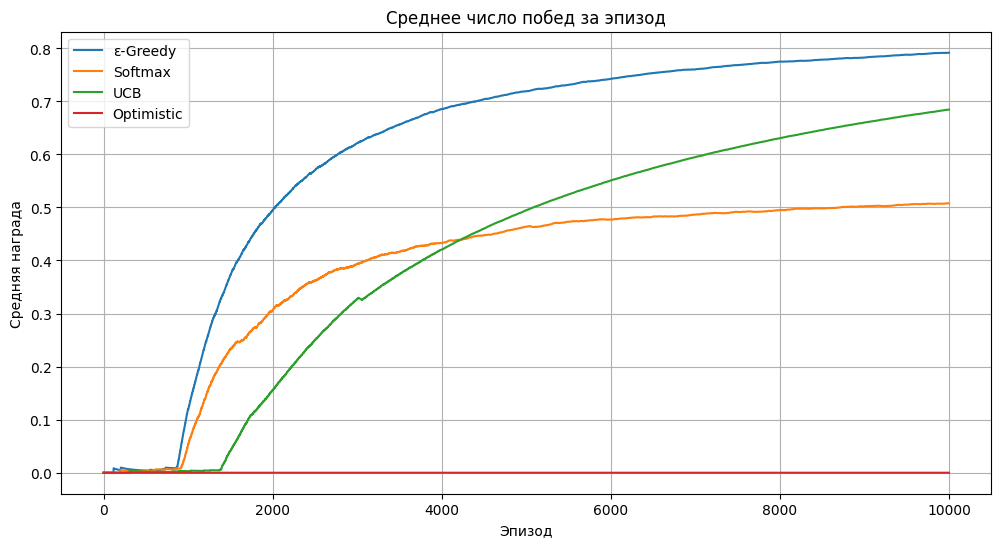

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for name, performance in results.items():
    plt.plot(performance, label=name)
plt.title("Среднее число побед за эпизод")
plt.xlabel("Эпизод")
plt.ylabel("Средняя награда")
plt.legend()
plt.grid()
plt.show()


# Влияние параметров

Запуск экспериментов: 100%|██████████| 10/10 [36:02<00:00, 216.21s/it]


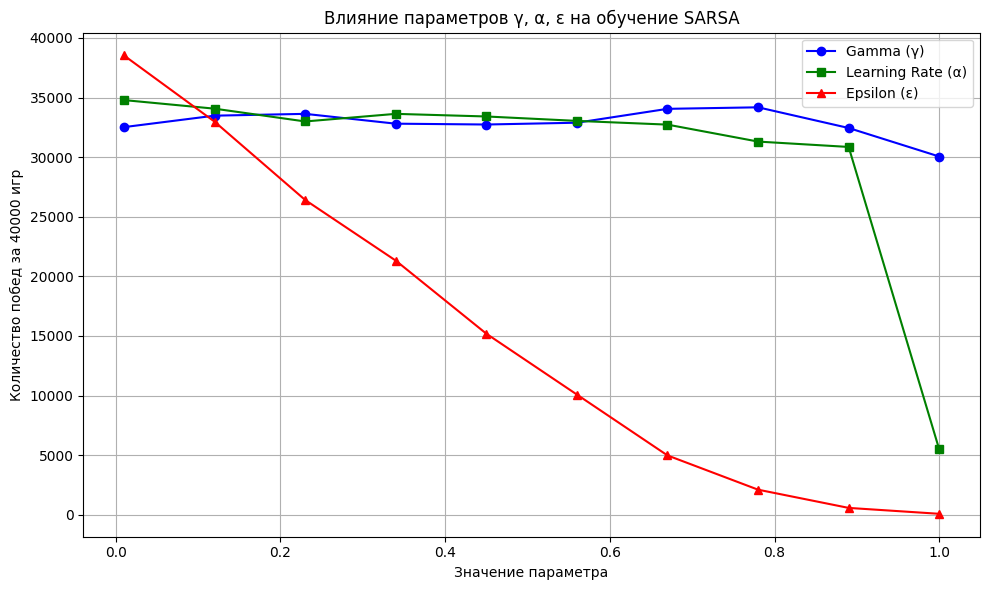

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def run_sarsa(gamma=0.9, lr_rate=0.1, epsilon=0.1, total_games=40000):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    total_wins = 0

    def choose_action(state):
        if np.random.uniform(0, 1) < epsilon:
            return np.random.randint(0, env.action_space.n)
        else:
            return np.random.choice(np.flatnonzero(Q[state] == Q[state].max()))

    def learn(state, state2, reward, action, action2, done):
        if done:
            Q[state, action] += lr_rate * (reward - Q[state, action])
        else:
            Q[state, action] += lr_rate * (reward + gamma * Q[state2, action2] - Q[state, action])

    for _ in range(total_games):
        state = env.reset()
        action = choose_action(state)
        for _ in range(100):
            state2, reward, done, _ = env.step(action)
            action2 = choose_action(state2)
            learn(state, state2, reward, action, action2, done)
            state, action = state2, action2
            if done and reward == 1:
                total_wins += 1
                break
    return total_wins

# Параметры для тестирования
x_values = np.linspace(0.01, 1.0, 10)
gamma_results = []
lr_results = []
epsilon_results = []

for val in tqdm(x_values, desc="Запуск экспериментов"):
    gamma_results.append(run_sarsa(gamma=val, lr_rate=0.1, epsilon=0.1))
    lr_results.append(run_sarsa(gamma=0.9, lr_rate=val, epsilon=0.1))
    epsilon_results.append(run_sarsa(gamma=0.9, lr_rate=0.1, epsilon=val))

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(x_values, gamma_results, marker='o', label='Gamma (γ)', color='blue')
plt.plot(x_values, lr_results, marker='s', label='Learning Rate (α)', color='green')
plt.plot(x_values, epsilon_results, marker='^', label='Epsilon (ε)', color='red')
plt.xlabel("Значение параметра")
plt.ylabel("Количество побед за 40000 игр")
plt.title("Влияние параметров γ, α, ε на обучение SARSA")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
